In [2]:
import pandas as pd




In [5]:
# Loading the dataset into a dataframe
df = pd.read_csv('heart.csv')

# Displaying the first few rows of the dataframe
df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0

In [6]:
from sklearn.preprocessing import LabelEncoder

# Create a new DataFrame to store the label-encoded data
df_encoded = df.copy()

# Identify the categorical columns that need to be label encoded
# In this case, all the categorical variables are already in numerical format.
# However, some are ordinal in nature, and we can apply label encoding to make sure they are treated as categories.
categorical_columns = ['cp', 'restecg', 'slope', 'ca', 'thal']

# Apply label encoding
label_encoder = LabelEncoder()
for column in categorical_columns:
    df_encoded[column] = label_encoder.fit_transform(df[column])

# Show the first few rows of the new DataFrame
df_encoded.head()


age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define the features and target variable
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize RFE (Recursive Feature Elimination) with the classifier and the number of top features to select
rfe = RFE(estimator=rf_classifier, n_features_to_select=1, step=1)

# Fit RFE
rfe = rfe.fit(X_train, y_train)

# Get the ranking of features
feature_ranking = rfe.ranking_

# Get the feature importances based on RFE
important_features = pd.Series(data=feature_ranking, index=X.columns)
important_features.sort_values(ascending=True, inplace=True)

# Predict using all features to establish a baseline
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred)

# Predict using only the top-ranked features to compare
top_features = important_features.index[:5]  # Select top 5 features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]
rf_classifier.fit(X_train_top, y_train)
y_pred_top = rf_classifier.predict(X_test_top)
top_features_accuracy = accuracy_score(y_test, y_pred_top)

important_features, baseline_accuracy, top_features_accuracy


(thalach      1
 oldpeak      2
 cp           3
 thal         4
 ca           5
 age          6
 chol         7
 trestbps     8
 exang        9
 slope       10
 sex         11
 restecg     12
 fbs         13
 dtype: int32,
 0.9853658536585366,
 0.9804878048780488)

In [ ]:
# Accuracy Comparison

#     Baseline Accuracy (using all features): 98.54%98.54%
#     Accuracy using top 5 ranked features: 98.05%98.05%
    
# Suggested Features

# The accuracy using the top 5 ranked features is very close to the baseline accuracy using all features. 
# Therefore, the top 5 features (thalach, oldpeak, cp, thal, ca) are highly relevant and 
# could be sufficient for predicting the target variable with high accuracy.

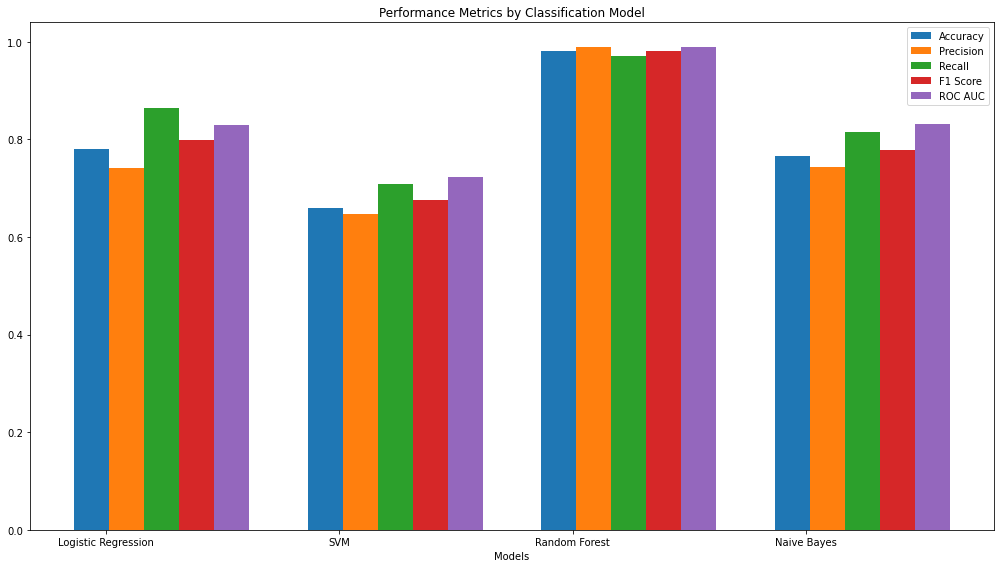

Accuracy Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.780488  0.741667  0.864078  0.798206  0.828479
SVM                  0.658537  0.646018  0.708738  0.675926  0.722587
Random Forest        0.980488  0.990099  0.970874  0.980392  0.988435
Naive Bayes          0.765854  0.743363  0.815534  0.777778  0.831049

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Select top 5 features for training
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

# Initialize a DataFrame to store performance metrics
metrics_RFE = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'], 
                                   index=classifiers.keys())

# Train models and evaluate performance
for name, clf in classifiers.items():
    # Train the model
    clf.fit(X_train_selected, y_train)
    
    # Make predictions on the test set
    y_pred = clf.predict(X_test_selected)
    y_proba = clf.predict_proba(X_test_selected)[:, 1]
    
    # Compute performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Store the performance metrics in the DataFrame
    metrics_RFE.loc[name, 'Accuracy'] = accuracy
    metrics_RFE.loc[name, 'Precision'] = precision
    metrics_RFE.loc[name, 'Recall'] = recall
    metrics_RFE.loc[name, 'F1 Score'] = f1score
    metrics_RFE.loc[name, 'ROC AUC'] = roc_auc

# Plotting the performance metrics
labels = metrics_RFE.index
metrics = metrics_RFE.columns

x = np.arange(len(labels))
width = 0.15

fig, ax = plt.subplots(figsize=(14, 8))

for i, metric in enumerate(metrics):
    ax.bar(x + i * width, metrics_RFE[metric], width, label=metric)

ax.set_xlabel('Models')
ax.set_title('Performance Metrics by Classification Model')
ax.set_xticks(x + width * 2 / 5)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

metrics_RFE


In [ ]:
# All Features 

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


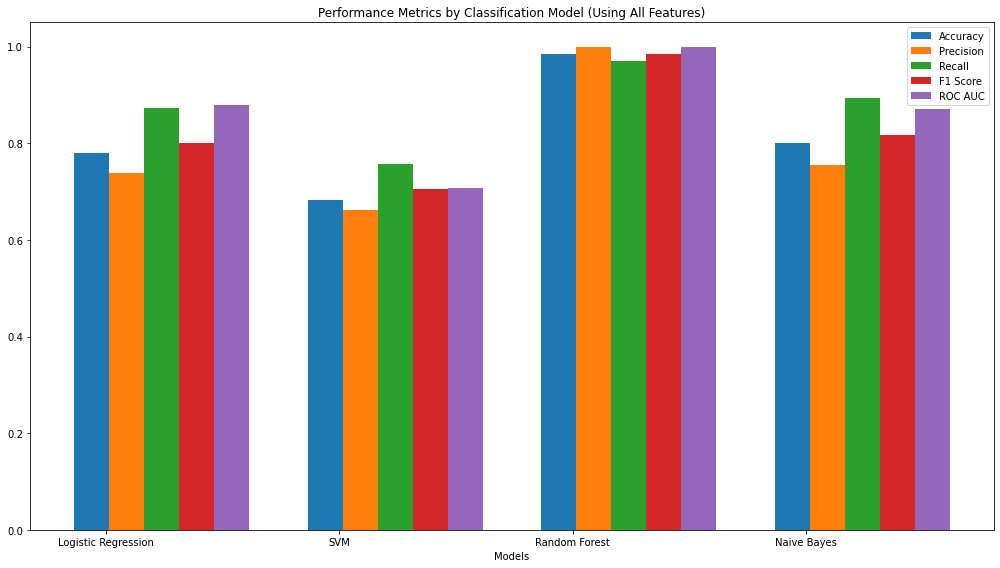

Accuracy Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.780488  0.737705  0.873786       0.8  0.879117
SVM                  0.682927  0.661017  0.757282  0.705882   0.70712
Random Forest        0.985366       1.0  0.970874  0.985222       1.0
Naive Bayes               0.8  0.754098  0.893204  0.817778   0.87055

In [9]:
# Initialize a DataFrame to store performance metrics for all features (except the target)
allfeature_metrics = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'], 
                                                index=classifiers.keys())

# Train models and evaluate performance using all features (except the target)
for name, clf in classifiers.items():
    # Train the model using all features
    clf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Compute performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Store the performance metrics in the DataFrame
    allfeature_metrics.loc[name, 'Accuracy'] = accuracy
    allfeature_metrics.loc[name, 'Precision'] = precision
    allfeature_metrics.loc[name, 'Recall'] = recall
    allfeature_metrics.loc[name, 'F1 Score'] = f1score
    allfeature_metrics.loc[name, 'ROC AUC'] = roc_auc

# Plotting the performance metrics for all features
fig, ax = plt.subplots(figsize=(14, 8))

for i, metric in enumerate(metrics):
    ax.bar(x + i * width, allfeature_metrics[metric], width, label=metric)

ax.set_xlabel('Models')
ax.set_title('Performance Metrics by Classification Model (Using All Features)')
ax.set_xticks(x + width * 2 / 5)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

allfeature_metrics


In [ ]:
#     Random Forest continues to be the most effective model across all performance metrics.
#     Logistic Regression and Naive Bayes have comparable performance and are effective to a certain extent.
#     SVM shows the lowest performance among the selected models based on these metrics.

# The bar plot visualizes these performance metrics for each classification model when all features are used for training.

In [10]:
# Forward selection

Selecting best feature set of size 1 ...


NameError: name 'svm_classifier' is not defined

In [11]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import make_scorer

# Initialize the SVM classifier
svm_classifier = SVC(probability=True, random_state=42)

# Initialize Sequential Feature Selector (SFS) for forward selection
sfs = SFS(svm_classifier, 
          k_features='best', 
          forward=True, 
          floating=False, 
          scoring=make_scorer(accuracy_score),
          cv=5)

# Fit SFS
sfs = sfs.fit(X_train, y_train)

# Get the selected features
selected_features_sfs = X_train.columns[list(sfs.k_feature_idx_)]

selected_features_sfs


Index(['sex', 'cp', 'restecg', 'exang', 'oldpeak', 'slope', 'ca', 'thal'], dtype='object')

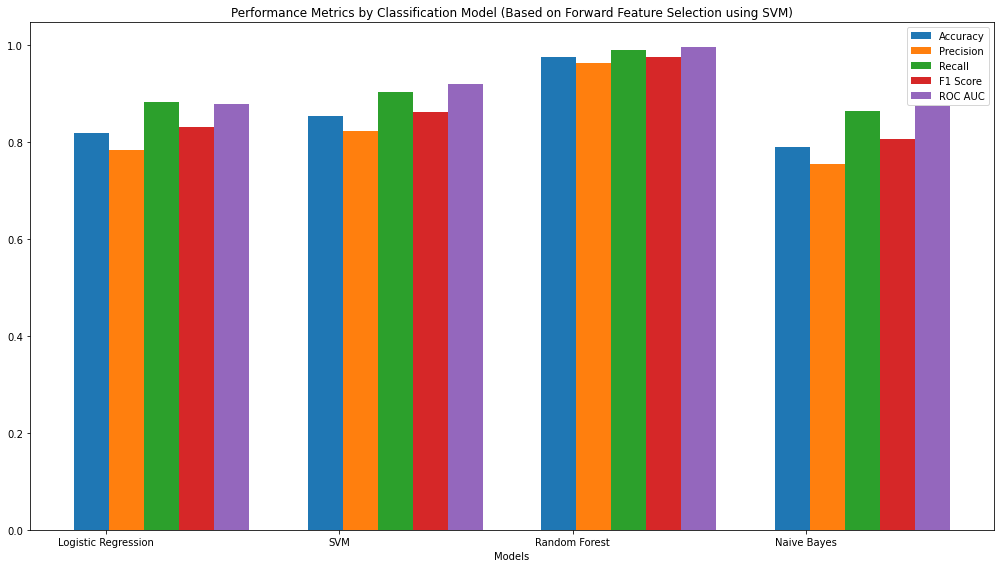

Accuracy Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.819512  0.784483  0.883495   0.83105  0.877879
SVM                  0.853659  0.823009  0.902913  0.861111  0.919855
Random Forest         0.97561  0.962264  0.990291  0.976077  0.996954
Naive Bayes          0.790244  0.754237  0.864078   0.80543   0.87331

In [12]:
# Initialize a DataFrame to store performance metrics based on Forward Feature Selection using SVM
performance_metrics_sfs = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'], 
                                       index=classifiers.keys())

# The selected features from Forward Feature Selection using SVM
#selected_features_sfs = ['sex', 'cp', 'restecg', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

# Prepare the training and testing data with selected features
X_train_sfs = X_train[selected_features_sfs]
X_test_sfs = X_test[selected_features_sfs]

# Train models and evaluate performance based on selected features
for name, clf in classifiers.items():
    # Train the model using selected features
    clf.fit(X_train_sfs, y_train)
    
    # Make predictions on the test set
    y_pred = clf.predict(X_test_sfs)
    y_proba = clf.predict_proba(X_test_sfs)[:, 1]
    
    # Compute performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Store the performance metrics in the DataFrame
    performance_metrics_sfs.loc[name, 'Accuracy'] = accuracy
    performance_metrics_sfs.loc[name, 'Precision'] = precision
    performance_metrics_sfs.loc[name, 'Recall'] = recall
    performance_metrics_sfs.loc[name, 'F1 Score'] = f1score
    performance_metrics_sfs.loc[name, 'ROC AUC'] = roc_auc

# Plotting the performance metrics based on Forward Feature Selection using SVM
fig, ax = plt.subplots(figsize=(14, 8))

for i, metric in enumerate(metrics):
    ax.bar(x + i * width, performance_metrics_sfs[metric], width, label=metric)

ax.set_xlabel('Models')
ax.set_title('Performance Metrics by Classification Model (Based on Forward Feature Selection using SVM)')
ax.set_xticks(x + width * 2 / 5)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

performance_metrics_sfs


In [ ]:

# Backward Selection 

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize the Logistic Regression classifier
logistic_classifier = LogisticRegression(random_state=42)

# Initialize Sequential Feature Selector (SFS) for backward selection
sfs_backward = SFS(logistic_classifier, 
                   k_features='best', 
                   forward=False, 
                   floating=False, 
                   scoring='accuracy',
                   cv=5)

# Fit SFS
sfs_backward = sfs_backward.fit(X_train, y_train)

# Get the selected features
selected_features_sfs_backward = X_train.columns[list(sfs_backward.k_feature_idx_)]

# The selected features are now stored in 'selected_features_sfs_backward'
print("Selected features:", selected_features_sfs_backward)


In [ ]:
# Selected features: Index(['age', 'sex', 'cp', 'restecg', 'thalach', 'oldpeak', 'slope', 'ca',
#        'thal'],
#       dtype='object')

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


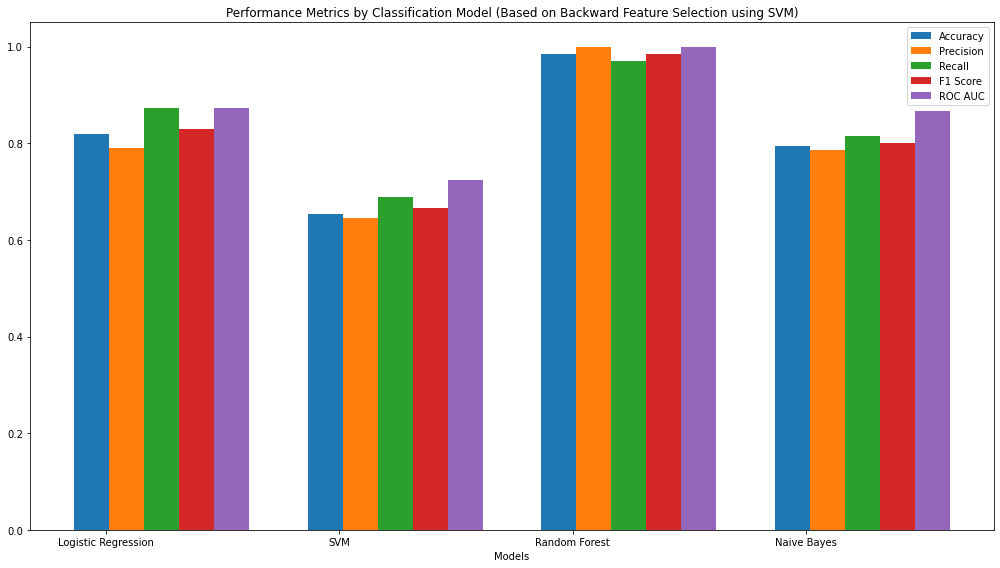

Accuracy Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.819512  0.789474  0.873786  0.829493  0.872549
SVM                  0.653659  0.645455   0.68932  0.666667  0.724824
Random Forest        0.985366       1.0  0.970874  0.985222       1.0
Naive Bayes          0.795122  0.785047  0.815534       0.8  0.866077

In [16]:
# Initialize a DataFrame to store performance metrics based on Forward Feature Selection using SVM
sfs_metrics = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'], 
                                       index=classifiers.keys())

# The selected features from Forward Feature Selection using SVM
#selected_features_sfs = ['sex', 'cp', 'restecg', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

# Prepare the training and testing data with selected features
X_train_sfs = X_train[selected_features_sfs_backward]
X_test_sfs = X_test[selected_features_sfs_backward]

# Train models and evaluate performance based on selected features
for name, clf in classifiers.items():
    # Train the model using selected features
    clf.fit(X_train_sfs, y_train)
    
    # Make predictions on the test set
    y_pred = clf.predict(X_test_sfs)
    y_proba = clf.predict_proba(X_test_sfs)[:, 1]
    
    # Compute performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Store the performance metrics in the DataFrame
    sfs_metrics.loc[name, 'Accuracy'] = accuracy
    sfs_metrics.loc[name, 'Precision'] = precision
    sfs_metrics.loc[name, 'Recall'] = recall
    sfs_metrics.loc[name, 'F1 Score'] = f1score
    sfs_metrics.loc[name, 'ROC AUC'] = roc_auc

# Plotting the performance metrics based on Forward Feature Selection using SVM
fig, ax = plt.subplots(figsize=(14, 8))

for i, metric in enumerate(metrics):
    ax.bar(x + i * width, sfs_metrics[metric], width, label=metric)

ax.set_xlabel('Models')
ax.set_title('Performance Metrics by Classification Model (Based on Backward Feature Selection using SVM)')
ax.set_xticks(x + width * 2 / 5)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

sfs_metrics
